In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython){
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import models as md
import matplotlib.pyplot as plt
%matplotlib inline

### Exploration

In [3]:
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
# data exploration - looking for empty values
data.count().unique()

array([299])

### Simple model example

In [5]:
TT = md.TreeTester(data=data,target='DEATH_EVENT')
TT.evaluate()

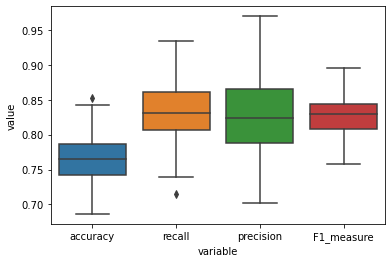

In [6]:
TT.plot_results()

In [7]:
# Train Size Test
# optimal train dataset size
# random extraction

train_size_array = np.arange(0.2,0.8,0.05)
accuracy_tst = []
recall_tst = []
precision_tst = []
F1_measure_tst = []
accuracy_tst_std = []
recall_tst_std = []
precision_tst_std = []
F1_measure_tst_std = []

for train_size in tqdm(train_size_array):
    TT = md.TreeTester(data=data,target='DEATH_EVENT',train_size=train_size,robustness_iterations=25)
    TT.evaluate()
    accuracy_tst.append(TT.evaluators.accuracy.mean())
    recall_tst.append(TT.evaluators.recall.mean())
    precision_tst.append(TT.evaluators.precision.mean())
    F1_measure_tst.append(TT.evaluators.F1_measure.mean())
    accuracy_tst_std.append(TT.evaluators.accuracy.std())
    recall_tst_std.append(TT.evaluators.recall.std())
    precision_tst_std.append(TT.evaluators.precision.std())
    F1_measure_tst_std.append(TT.evaluators.F1_measure.std())

  0%|          | 0/13 [00:00<?, ?it/s]

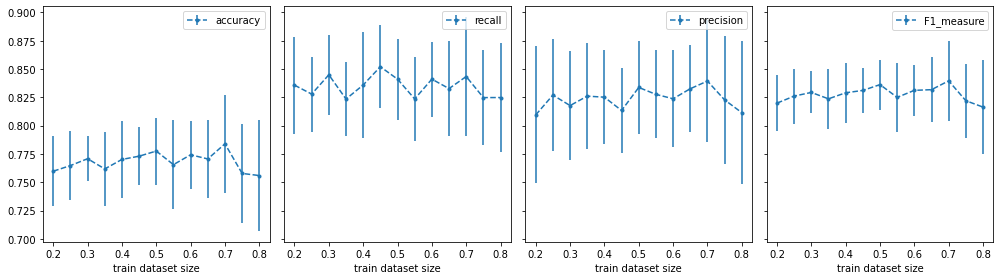

In [8]:
fig,axs = plt.subplots(1,4,figsize=(14,4),sharey=True)

axs[0].errorbar(train_size_array,accuracy_tst,yerr=accuracy_tst_std,fmt='.--',label='accuracy')
axs[1].errorbar(train_size_array,recall_tst,yerr=recall_tst_std,fmt='.--',label='recall')
axs[2].errorbar(train_size_array,precision_tst,yerr=precision_tst_std,fmt='.--',label='precision')
axs[3].errorbar(train_size_array,F1_measure_tst,yerr=F1_measure_tst_std,fmt='.--',label='F1_measure')

for ax in axs:
    ax.set_xlabel('train dataset size')
    ax.legend()

fig.tight_layout()

In [10]:
# optimal train dataset size
# stratified sampling

In [11]:
# feature selection

In [ ]:
# oversampling